In [5]:
import torch
import sys

sys.path.append('..')

from ops.models import TSN

In [6]:
#python main.py Assembly101 combined --arch resnet50 --num_segments 8 --gd 20 --lr 0.001 --lr_steps 20 40 --epochs 50 --batch-size 64 -j 16 --dropout 0.5 --consensus_type=avg --eval-freq=1 --shift --shift_div=8 --shift_place=blockres --npb --tune_from=pretrained_models/tsm_rgb_epic.ckpt

In [7]:
net = TSN(1380, 8, 'RGB', base_model='resnet50', consensus_type='avg', img_feature_dim=256,pretrain='imagenet',is_shift=True,shift_div=8, shift_place='blockres',non_local=False, dropout=0.5, partial_bn=True)
# net = TSN(1380, 1, 'RGB', base_model='resnet50', consensus_type='avg', img_feature_dim=256,pretrain='imagenet',is_shift=False, non_local=False, dropout=0.5, partial_bn=True)


    Initializing TSN with base model: resnet50.
    TSN Configurations:
        input_modality:     RGB
        num_segments:       8
        new_length:         1
        consensus_module:   avg
        dropout_ratio:      0.5
        img_feature_dim:    256
            
=> base model: resnet50
Adding temporal shift...
=> n_segment per stage: [8, 8, 8, 8]
=> Processing stage with 3 blocks residual
=> Using fold div: 8
=> Using fold div: 8
=> Using fold div: 8
=> Processing stage with 4 blocks residual
=> Using fold div: 8
=> Using fold div: 8
=> Using fold div: 8
=> Using fold div: 8
=> Processing stage with 6 blocks residual
=> Using fold div: 8
=> Using fold div: 8
=> Using fold div: 8
=> Using fold div: 8
=> Using fold div: 8
=> Using fold div: 8
=> Processing stage with 3 blocks residual
=> Using fold div: 8
=> Using fold div: 8
=> Using fold div: 8


In [8]:
ckpt = torch.load("../pretrained_models/TSM_Assembly101_combined_resnet50_shift8_blockres_avg_segment8_e50.pth", weights_only=False)
checkpoint = ckpt['state_dict']

sd = {'.'.join(k.split('.')[1:]): v for k, v in list(checkpoint.items())}
# for k,v in list(sd.items()):
#     if 'net.' in k:
#         sd[k.replace('net.','')] = sd.pop(k)
replace_dict = {'base_model.classifier.weight': 'new_fc.weight',
                'base_model.classifier.bias': 'new_fc.bias',
                }
for k, v in replace_dict.items():
    if k in sd:
        sd[v] = sd.pop(k)

net.load_state_dict(sd)
net.eval()
net = net.to('cuda')

In [9]:
# # dummy_input = torch.randn(1, 3, 8, 224, 224)
# dummy_input = torch.randn(1, 3, 100, 224, 224, device='cuda')
# output = net(dummy_input)
# print(output.shape)
# feature = net.extract_feature(dummy_input)
# print(feature.shape)

In [22]:
import torchvision
from ops.transforms import GroupScale, GroupCenterCrop, Stack, ToTorchFormatTensor, GroupNormalize
from torchvision.transforms import v2
this_arch = 'resnet50'
input_size = net.input_size

transform = v2.Compose([
            v2.ToImage(),
            v2.Resize(224),
            v2.CenterCrop(224),
            v2.ToDtype(torch.float32, scale=True),
            v2.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
        ])

In [23]:
start, stop, step = 0, 5000, 50

In [ ]:
import numpy as np

In [52]:
video_path = '/home/fitz_joye/TSM-action-recognition/data/assembly101/resized/nusar-2021_action_both_9073-a18_9073_user_id_2021-02-11_140513/C10404_rgb.mp4'

from decord import VideoReader, cpu, gpu


vr = VideoReader(video_path, ctx=cpu(0))
frames = vr.get_batch(np.arange(0, 43, 6))
images = [frame for frame in frames.asnumpy()]
images = transform(images)
images = torch.stack(images, dim=0)
images = images.reshape(-1, 224, 224)
# images = torch.stack([images, images, images])
print(images.shape, type(images))

torch.Size([24, 224, 224]) <class 'torch.Tensor'>


In [54]:
feature = net.extract_feature(images.cuda()).mean(dim=0)
print(feature.shape)
feature = feature.cpu().detach().numpy()

torch.Size([2048])


In [ ]:
np_feat = np.load('/mnt/public/assembly101/TSM_features_np/nusar-2021_action_both_9073-a18_9073_user_id_2021-02-11_140513/C10404_rgb/features.npy')
np_feat = np_feat.T
print(np_feat.shape)
np_feat = np_feat[start:stop:step]
np_feat.shape

(11683, 2048)


(100, 2048)

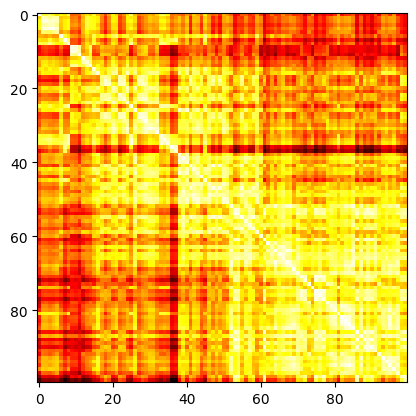

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity
from matplotlib import pyplot as plt
sim = cosine_similarity(feature, np_feat)
plt.imshow(sim, cmap='hot', interpolation='nearest')

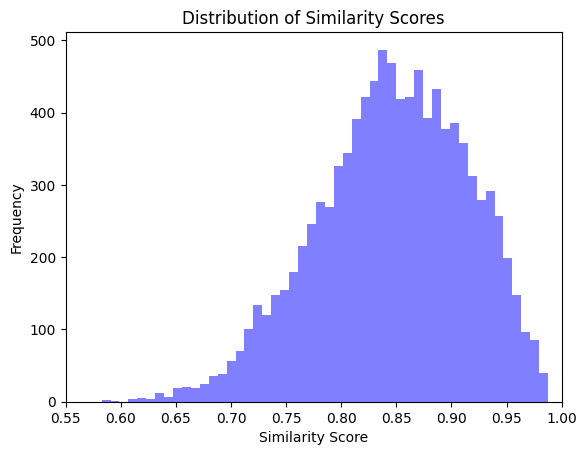

(0.55, 1.0)

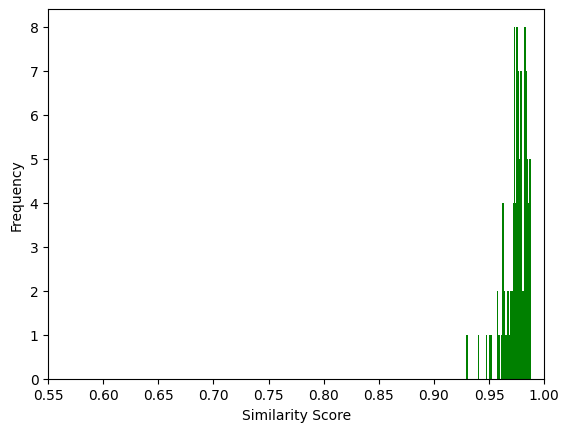

In [ ]:
plt.hist(sim.flatten(), bins=50, color='blue', alpha=0.5)
plt.title('Distribution of Similarity Scores')
plt.xlabel('Similarity Score')
plt.ylabel('Frequency')
plt.xlim(0.55,1.00)
plt.show()

plt.hist(np.diag(sim), bins=50, color='green', alpha=1)
plt.xlabel('Similarity Score')
plt.ylabel('Frequency')
plt.xlim(0.55,1.00)

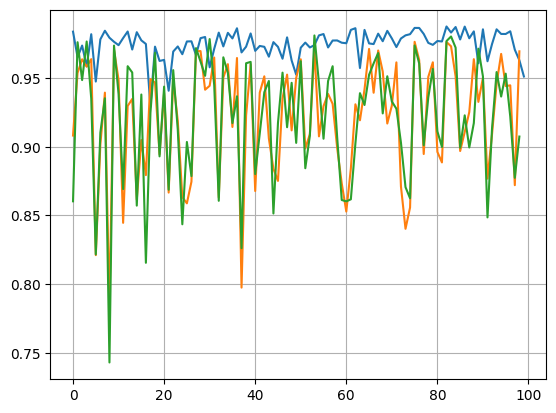

In [ ]:
plt.plot(sim.diagonal())
plt.plot(sim.diagonal(1))
plt.plot(sim.diagonal(-1))
plt.grid()
# plt.ylim(0, 1)

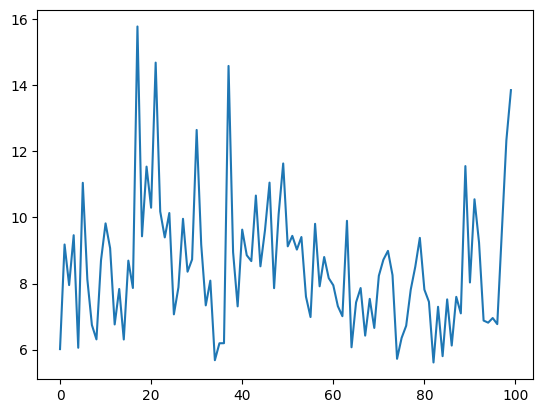

In [ ]:
plt.plot(np.linalg.norm((np_feat - feature), axis=1))